# Use Filtered Data and Shuffle Training

Data:
    - filter out more hackers, admins, suppliers
    - do not include users with only 1 click
Model: 
    - seperate embeddings between suppliers and users
    - high regularization
    - padding for users - but maskAware average
    - leaky relu instead of relu
 
Training:
    - no pretraining
    - shuffling to see if i get speed up

In [4]:
import numpy as np
import tensorflow as tf
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(1)

from keras import initializers
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Embedding, Input, Dense, merge, Flatten, concatenate, multiply, dot, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
import keras.callbacks
from time import time
import pdb
from scipy import sparse
import pickle
import sqlite3

Using TensorFlow backend.


In [ ]:
import sqlalchemy as db
from sqlalchemy import create_engine
import psycopg2

In [ ]:
import random
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

In [ ]:
# DATABASE_URI = ###
# engine = create_engine(DATABASE_URI)
engine = sqlite3.connect('data/db.db', check_same_thread=False)

## Select Parameters and Create Model

Parameters to create the model and train 

In [5]:
# Parameters
# Model
# MLP
layers = [128,64,32,16] #[378,162,42,14]
reg_layers = [0.01, 0.01, 0.01, 0.01] #[0.04,0.0001,0.01,0.01] #
# MF
reg_mf = 0.01 #0.0003 
#num_negatives = args.num_neg
learning_rate = 0.001

In [6]:
# size of embeddings = embedding_dimensions = number_of_categories**0.25
# months = 13
# supplier = 563
# wgs = 230
# mkt = 9

# months_emb = round(months ** 0.25)
# supplier_emb = round(supplier ** 0.25)
# wgs_emb = round(wgs ** 0.25)
# mkt_emb = round(mkt ** 0.25)

In [7]:
import Hybrid_NeuMF

In [8]:
model = Hybrid_NeuMF.get_model(layers, reg_layers, reg_mf)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_mkt (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_wg (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
user_anbieter (InputLayer)      (None, 200)          0                                            
__________________________________________________________________________________________________
month (InputLayer)              (None, 1)            0                                           

## Set Training Parameters and Train model

In [10]:
batch_size = 256 # should be as large as fits in memory

In [11]:
query = ('''SELECT  t.[index]
            FROM    target_training_enc as t 
                    LEFT JOIN training_user_filter as f
                        ON t.userid = f.userid
            WHERE   f.userid IS NULL''')
indices = pd.read_sql(query, engine)

In [12]:
# Training 
num_epochs = 50 # the more the merrier
total_size = len(indices) # to leave out one for validation
#val_size = 0.1
train_size = round(0.9*total_size) # to leave out 10% one for validation
verbose = 1
save = 1 # 1 = save model, 0 = dont save model

In [13]:
indices_train = indices[:train_size]

In [14]:
len(indices_train)

9092673

In [15]:
train_list = indices_train['index'].values.tolist()

In [16]:
indices_val = indices[train_size:]

In [17]:
len(indices_val)

926762

In [18]:
val_list = indices_val['index'].values.tolist()

Create Name and History of this run - save model architecture

In [1]:
name = 'data/models/training/4_2_leaky_relu_high_reg'

In [20]:
# Parameters
# Init performance
best_val_roc = 0 #0.8519514799118042 #0
history_all = []

# Model save to
model_out_file = str(name +'_weights.h5')
print (model_out_file)

# History save to 
path_history = str(name + '_history.pkl')

4_2_leaky_relu_high_reg_weights.h5


### Batches - generate batches and feed to model

In [21]:
import generators
import evaluate

In [22]:
from sklearn.metrics import roc_auc_score

Define function to calculate the roc score across the validation data

In [23]:
Define function to calculate the roc score across the validation datadef roc_all (model, val_indexi):
    y_all = []
    predict_all = []
    for batches in range(0, len(val_indexi), 50000):
        indeci = tuple(val_list[batches:batches+50000])
        query_v = f"""
            SELECT * FROM target_training_enc where [index] IN {indeci}
        """
        data = pd.read_sql_query(query_v, engine)
        data_p = evaluate.transform_log(data, 200)
        # select truth and make prediction
        y_true = data.pick.values.flatten().tolist()
        y_score = model.predict(x = data_p).flatten().tolist()
        y_all.append(y_true)
        predict_all.append(y_score)
    # flatten all results
    flat_list_y = [item for sublist in y_all for item in sublist]
    flat_list_predict = [item for sublist in predict_all for item in sublist]
    # make arrays
    y_array = np.array(flat_list_y, ndmin = 2).reshape(-1,1)
    pred_array = np.array(flat_list_predict, ndmin =2).reshape(-1,1)
    # calc roc
    roc = roc_auc_score(y_array, pred_array)
    return(roc)

Train model and save best iteration

In [24]:
for epoch in range(num_epochs):
    t1 = time()
    print (epoch)
    random.shuffle(train_list)
    random.shuffle(val_list)
    gen = generators.generate_batches_shuffle_new(engine = engine, batch_size=batch_size, train_list = train_list)
    val = generators.generate_batches_shuffle_new(engine = engine, batch_size=batch_size, train_list = val_list)

### train model - validation data to also get validation loss at the end of epoch
    hist = model.fit_generator(gen, steps_per_epoch = np.ceil(len(train_list)/ batch_size), epochs=1 ,verbose=1, validation_data = val, validation_steps = 1)
    t2 = time()


    # Evaluation
    if epoch % verbose == 0:
        loss = hist.history['loss'][0]
        # evaluate auroc per user
        val_roc = roc_all(model, val_list)
        # append result to history 
        hist.history.update({'val_uroc' : val_roc})
        # print results of evaluation
        print('Iteration %d [%.1f s]: Loss = %.4f, Validation AUC = %.4f [%.1f s]'
              % (epoch,  t2-t1, loss, val_roc, time()-t2))
        # save model if val_auc better than max
        if val_roc > best_val_roc:
            best_loss, best_val_roc, best_iter = loss, val_roc, epoch
            if save > 0:
                model.save_weights(model_out_file, overwrite=True)
                
    # save history after each epoch
    history_all.append(hist.history)
    with open(path_history, 'wb') as fp:
        pickle.dump(history_all, fp)

print("End. Best Iteration %d: Loss = %.4f & Area under the Curve = %.4f. " %(best_iter, best_loss, best_val_roc))
if save > 0:
    print("The best NeuMF model is saved to %s" % model_out_file)

0

Epoch 1/1
35519/35519 [==============================] - 5771s 162ms/step - loss: 0.5772 - val_loss: 0.5678
Iteration 0 [5786.4 s]: Loss = 0.5772, Validation UROC = 0.6608 [610.5 s]
1
Epoch 1/1
35519/35519 [==============================] - 5741s 162ms/step - loss: 0.5707 - val_loss: 0.5964
Iteration 1 [5754.2 s]: Loss = 0.5707, Validation UROC = 0.6651 [614.1 s]
2
Epoch 1/1
35519/35519 [==============================] - 5723s 161ms/step - loss: 0.5698 - val_loss: 0.5731
Iteration 2 [5735.7 s]: Loss = 0.5698, Validation UROC = 0.6643 [611.3 s]
3
Epoch 1/1
35519/35519 [==============================] - 5759s 162ms/step - loss: 0.5693 - val_loss: 0.5711
Iteration 3 [5772.0 s]: Loss = 0.5693, Validation UROC = 0.6633 [614.7 s]
4
Epoch 1/1
34648/35519 [============================>.] - ETA: 2:21 - loss: 0.5691

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5577/35519 [===>..........................] - ETA: 1:21:27 - loss: 0.5697

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12111/35519 [=========>....................] - ETA: 1:02:58 - loss: 0.5692

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18824/35519 [==============>...............] - ETA: 44:44 - loss: 0.5688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24529/35519 [===================>..........] - ETA: 29:24 - loss: 0.5689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31272/35519 [=========================>....] - ETA: 11:22 - loss: 0.5689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 5742s 162ms/step - loss: 0.5689 - val_loss: 0.5929
Iteration 5 [5754.7 s]: Loss = 0.5689, Validation UROC = 0.6643 [615.6 s]
6
Epoch 1/1
 2226/35519 [>.............................] - ETA: 1:32:07 - loss: 0.5687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8504/35519 [======>.......................] - ETA: 1:13:10 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15149/35519 [===========>..................] - ETA: 54:46 - loss: 0.5690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21942/35519 [=================>............] - ETA: 36:25 - loss: 0.5690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25736/35519 [====================>.........] - ETA: 26:13 - loss: 0.5690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28601/35519 [=======================>......] - ETA: 18:31 - loss: 0.5690

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32424/35519 [==========================>...] - ETA: 8:19 - loss: 0.5688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35237/35519 [============================>.] - ETA: 45s - loss: 0.5688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3253/35519 [=>............................] - ETA: 1:28:30 - loss: 0.5692

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6171/35519 [====>.........................] - ETA: 1:19:47 - loss: 0.5687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9775/35519 [=======>......................] - ETA: 1:09:30 - loss: 0.5688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12295/35519 [=========>....................] - ETA: 1:02:33 - loss: 0.5689

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16017/35519 [============>.................] - ETA: 52:22 - loss: 0.5688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 5764s 162ms/step - loss: 0.5686 - val_loss: 0.5842
Iteration 7 [5777.2 s]: Loss = 0.5686, Validation UROC = 0.6601 [620.6 s]
8
Epoch 1/1
35519/35519 [==============================] - 5792s 163ms/step - loss: 0.5686 - val_loss: 0.5348
Iteration 8 [5804.9 s]: Loss = 0.5686, Validation UROC = 0.6631 [617.1 s]
9
Epoch 1/1
35519/35519 [==============================] - 5772s 163ms/step - loss: 0.5685 - val_loss: 0.5541
Iteration 9 [5785.7 s]: Loss = 0.5685, Validation UROC = 0.6621 [616.4 s]
10
Epoch 1/1
35519/35519 [==============================] - 5766s 162ms/step - loss: 0.5685 - val_loss: 0.5504
Iteration 10 [5779.7 s]: Loss = 0.5685, Validation UROC = 0.6627 [618.3 s]
11
Epoch 1/1
35519/35519 [==============================] - 6123s 172ms/step - loss: 0.5684 - val_loss: 0.6092
Iteration 11 [6135.9 s]: Loss = 0.5684, Validation UROC = 0.6591 [647.7 s]
12
Epoch 1/1
35519/35519 [==============================] - 6266s 176ms/step - loss: 0.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 6259s 176ms/step - loss: 0.5683 - val_loss: 0.5731
Iteration 14 [6273.2 s]: Loss = 0.5683, Validation UROC = 0.6632 [647.2 s]
15
Epoch 1/1
35519/35519 [==============================] - 6258s 176ms/step - loss: 0.5682 - val_loss: 0.5601
Iteration 15 [6271.7 s]: Loss = 0.5682, Validation UROC = 0.6623 [651.9 s]
16
Epoch 1/1
35519/35519 [==============================] - 6280s 177ms/step - loss: 0.5682 - val_loss: 0.5794
Iteration 16 [6294.1 s]: Loss = 0.5682, Validation UROC = 0.6634 [650.1 s]
17
Epoch 1/1
25492/35519 [====================>.........] - ETA: 29:10 - loss: 0.5681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31969/35519 [==========================>...] - ETA: 10:23 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3174/35519 [=>............................] - ETA: 1:34:55 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9655/35519 [=======>......................] - ETA: 1:15:54 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13849/35519 [==========>...................] - ETA: 1:03:36 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16187/35519 [============>.................] - ETA: 56:29 - loss: 0.5685

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19821/35519 [===============>..............] - ETA: 45:39 - loss: 0.5684

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22103/35519 [=================>............] - ETA: 38:56 - loss: 0.5683

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27546/35519 [======================>.......] - ETA: 23:03 - loss: 0.5683

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33733/35519 [===========================>..] - ETA: 5:12 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4598/35519 [==>...........................] - ETA: 1:30:07 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10850/35519 [========>.....................] - ETA: 1:12:27 - loss: 0.5686

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17368/35519 [=============>................] - ETA: 52:58 - loss: 0.5683

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23755/35519 [===================>..........] - ETA: 34:05 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28525/35519 [=======================>......] - ETA: 20:13 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35117/35519 [============================>.] - ETA: 1:10 - loss: 0.5681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5955/35519 [====>.........................] - ETA: 1:25:36 - loss: 0.5677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 6219s 175ms/step - loss: 0.5681 - val_loss: 0.5897
Iteration 20 [6232.5 s]: Loss = 0.5681, Validation UROC = 0.6641 [653.3 s]
21
Epoch 1/1
35519/35519 [==============================] - 6208s 175ms/step - loss: 0.5681 - val_loss: 0.5571
Iteration 21 [6222.2 s]: Loss = 0.5681, Validation UROC = 0.6644 [654.5 s]
22
Epoch 1/1
35519/35519 [==============================] - 6602s 186ms/step - loss: 0.5681 - val_loss: 0.6069
Iteration 22 [6616.0 s]: Loss = 0.5681, Validation UROC = 0.6631 [644.7 s]
23
Epoch 1/1
35519/35519 [==============================] - 8787s 247ms/step - loss: 0.5681 - val_loss: 0.5716
Iteration 23 [8800.3 s]: Loss = 0.5681, Validation UROC = 0.6623 [784.3 s]
24
Epoch 1/1
35519/35519 [==============================] - 8829s 249ms/step - loss: 0.5680 - val_loss: 0.6271
Iteration 24 [8844.9 s]: Loss = 0.5680, Validation UROC = 0.6610 [843.6 s]
25
Epoch 1/1
35519/35519 [==============================] - 8821s 248ms/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17283/35519 [=============>................] - ETA: 1:15:23 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22627/35519 [==================>...........] - ETA: 52:57 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27596/35519 [======================>.......] - ETA: 32:28 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34094/35519 [===========================>..] - ETA: 5:52 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3587/35519 [==>...........................] - ETA: 2:11:23 - loss: 0.5674

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8557/35519 [======>.......................] - ETA: 1:49:15 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14041/35519 [==========>...................] - ETA: 1:28:34 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19306/35519 [===============>..............] - ETA: 1:06:34 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24431/35519 [===================>..........] - ETA: 45:17 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29494/35519 [=======================>......] - ETA: 24:46 - loss: 0.5681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34494/35519 [============================>.] - ETA: 4:13 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4096/35519 [==>...........................] - ETA: 2:08:30 - loss: 0.5677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5881/35519 [===>..........................] - ETA: 2:00:22 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9293/35519 [======>.......................] - ETA: 1:45:30 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11487/35519 [========>.....................] - ETA: 1:37:13 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14549/35519 [===========>..................] - ETA: 1:26:09 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16468/35519 [============>.................] - ETA: 1:18:19 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19475/35519 [===============>..............] - ETA: 1:05:25 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21254/35519 [================>.............] - ETA: 58:05 - loss: 0.5681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24284/35519 [===================>..........] - ETA: 45:40 - loss: 0.5681

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26422/35519 [=====================>........] - ETA: 36:56 - loss: 0.5682

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 8729s 246ms/step - loss: 0.5680 - val_loss: 0.5884
Iteration 30 [8746.6 s]: Loss = 0.5680, Validation UROC = 0.6635 [812.0 s]
31
Epoch 1/1
35519/35519 [==============================] - 8011s 226ms/step - loss: 0.5680 - val_loss: 0.5728
Iteration 31 [8028.8 s]: Loss = 0.5680, Validation UROC = 0.6624 [810.7 s]
32
Epoch 1/1
35519/35519 [==============================] - 7921s 223ms/step - loss: 0.5680 - val_loss: 0.5164
Iteration 32 [7939.1 s]: Loss = 0.5680, Validation UROC = 0.6638 [793.6 s]
33
Epoch 1/1
35519/35519 [==============================] - 7958s 224ms/step - loss: 0.5679 - val_loss: 0.5676
Iteration 33 [7975.1 s]: Loss = 0.5679, Validation UROC = 0.6640 [821.9 s]
34
Epoch 1/1
35519/35519 [==============================] - 7792s 219ms/step - loss: 0.5679 - val_loss: 0.6164
Iteration 34 [7807.8 s]: Loss = 0.5679, Validation UROC = 0.6613 [811.7 s]
35
Epoch 1/1
35519/35519 [==============================] - 7905s 223ms/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8839/35519 [======>.......................] - ETA: 1:37:36 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14893/35519 [===========>..................] - ETA: 1:15:44 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20982/35519 [================>.............] - ETA: 53:51 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27151/35519 [=====================>........] - ETA: 30:49 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33639/35519 [===========================>..] - ETA: 6:58 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4139/35519 [==>...........................] - ETA: 1:57:49 - loss: 0.5677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10519/35519 [=======>......................] - ETA: 1:31:33 - loss: 0.5678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16323/35519 [============>.................] - ETA: 1:10:20 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22328/35519 [=================>............] - ETA: 46:15 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28551/35519 [=======================>......] - ETA: 23:32 - loss: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35281/35519 [============================>.] - ETA: 48s - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5919/35519 [===>..........................] - ETA: 1:27:55 - loss: 0.5676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10246/35519 [=======>......................] - ETA: 1:16:43 - loss: 0.5676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16251/35519 [============>.................] - ETA: 1:00:19 - loss: 0.5677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22331/35519 [=================>............] - ETA: 42:11 - loss: 0.5677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28713/35519 [=======================>......] - ETA: 22:14 - loss: 0.5678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34175/35519 [===========================>..] - ETA: 4:25 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4810/35519 [===>..........................] - ETA: 1:34:46 - loss: 0.5676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10989/35519 [========>.....................] - ETA: 1:14:51 - loss: 0.5678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17343/35519 [=============>................] - ETA: 55:27 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23671/35519 [==================>...........] - ETA: 35:45 - loss: 0.5679

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35519/35519 [==============================] - 6487s 183ms/step - loss: 0.5679 - val_loss: 0.5896
Iteration 41 [6502.3 s]: Loss = 0.5679, Validation UROC = 0.6649 [658.6 s]
42
Epoch 1/1
35519/35519 [==============================] - 6735s 190ms/step - loss: 0.5678 - val_loss: 0.5922
Iteration 42 [6750.0 s]: Loss = 0.5678, Validation UROC = 0.6637 [671.3 s]
43
Epoch 1/1
35519/35519 [==============================] - 5992s 169ms/step - loss: 0.5679 - val_loss: 0.6088
Iteration 43 [6006.0 s]: Loss = 0.5679, Validation UROC = 0.6601 [633.5 s]
44
Epoch 1/1
35519/35519 [==============================] - 5928s 167ms/step - loss: 0.5679 - val_loss: 0.5839
Iteration 44 [5941.1 s]: Loss = 0.5679, Validation UROC = 0.6637 [631.0 s]
45
Epoch 1/1
35519/35519 [==============================] - 5789s 163ms/step - loss: 0.5678 - val_loss: 0.6215
Iteration 45 [5801.8 s]: Loss = 0.5678, Validation UROC = 0.6621 [620.7 s]
46
Epoch 1/1
35519/35519 [==============================] - 5799s 163ms/step - loss

In [ ]:
model_out_file

# Plots

In [2]:
path_history = str(name + '_history.pkl')

In [5]:
history_all = pickle.load( open(path_history, "rb" ) )

In [6]:
history_all

[{'val_loss': [0.567840039730072],
  'loss': [0.5771597894463032],
  'val_uroc': 0.6607529874781847},
 {'val_loss': [0.5963725447654724],
  'loss': [0.5706568029389596],
  'val_uroc': 0.665099142595381},
 {'val_loss': [0.5731121301651001],
  'loss': [0.5697837672420266],
  'val_uroc': 0.6642776294006465},
 {'val_loss': [0.5711070895195007],
  'loss': [0.5692914277438099],
  'val_uroc': 0.663254531963638},
 {'val_loss': [0.5968745946884155],
  'loss': [0.5690551007287072],
  'val_uroc': 0.6622312872545498},
 {'val_loss': [0.5928779244422913],
  'loss': [0.568878874494955],
  'val_uroc': 0.6643063509721384},
 {'val_loss': [0.6439414620399475],
  'loss': [0.5687669460246159],
  'val_uroc': 0.661439183110394},
 {'val_loss': [0.5841836333274841],
  'loss': [0.5686196680355917],
  'val_uroc': 0.6601200979239882},
 {'val_loss': [0.5348444581031799],
  'loss': [0.5686117206986613],
  'val_uroc': 0.6631061028529299},
 {'val_loss': [0.5541207790374756],
  'loss': [0.5684984697614638],
  'val_uro

In [7]:
len(history_all)

50

In [8]:
from matplotlib import pyplot as plt

## Loss

In [9]:
loss = []
for i in range(0, len(history_all)):
    loss.append(history_all[i]['loss'][0])

val_loss = []
for i in range(0, len(history_all)):
    val_loss.append(history_all[i]['val_loss'][0])

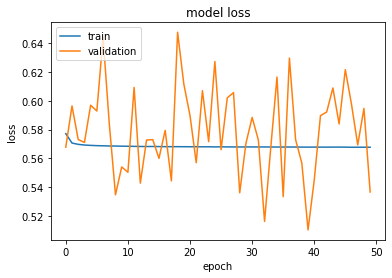

In [10]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## AUROC

AUROC does not use the fixed continuous data... 

In [11]:
val_auroc = []
for i in range(0, len(history_all)):
    try:
        val_auroc.append(history_all[i]['val_uroc'])
    except:
        pass

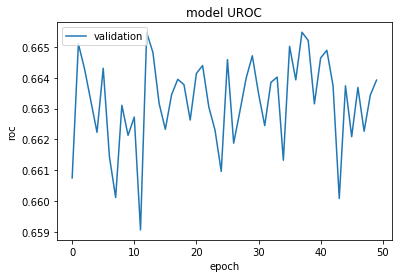

In [12]:
plt.plot(val_auroc)
plt.title('model UROC')
plt.ylabel('roc')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper left')
plt.show()

In [13]:
max(val_auroc)

0.665472790528151